In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import contrib 
import pandas as pd
from tensorflow.python.framework import ops
import urllib
import random
from math import exp
from math import log

%matplotlib inline
np.random.seed(1)

In [2]:
# Format data
def format_data(filename):
    training = open(filename)
    header = training.readline()
    fields = header.strip().replace('"','').split(',')
    featureNames = fields[:-1]
    labelName = fields[-1]
    lines = [[float(x) for x in l.split(',')] for l in training]
    X = [l[:-1] for l in lines]
    Y = [l[-1] for l in lines]
    X = np.matrix(X).T
    Y = np.array(Y)
    Y = Y.astype(int)
    nb_classes = 15
    Y = np.eye(nb_classes)[Y]
    Y = Y.T
    print(Y.T[2,])
    return X, Y

In [3]:
# Format Training Set
X_train, Y_train = format_data('training.csv')
print(Y_train.shape)
print(X_train.shape)

# Format Dev Set
X_dev, Y_dev = format_data('dev.csv')
print(Y_dev.shape)
print(X_dev.shape)

# Format Test Set
X_test, Y_test = format_data('test.csv')
print(Y_test.shape)
print(X_test.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(15, 10224)
(12, 10224)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(15, 1281)
(12, 1281)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(15, 1274)
(12, 1274)


In [4]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [5]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [15, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [15,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                               # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)   
    return Z3

In [7]:
def compute_cost(Z, Y):
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    return cost

In [23]:
def model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 32, print_cost = True):
       
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    (n_x_dev, m_dev) = X_dev.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y_dev = Y_dev.shape[0]                            # n_y : output size
    training_costs = []                                        # To keep track of the cost
    dev_costs = []
    
    tfe = contrib.eager
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    X_dev_PH, Y_dev_PH = create_placeholders(n_x_dev, n_y_dev)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            _ , training_cost = sess.run([optimizer, cost], feed_dict={X: X_train, 
                                                                       Y: Y_train})

            # Print the training and dev cost at every 1000 epoch
            if print_cost == True and epoch % 500 == 0:
                print ("Training Cost after epoch %i: %f" % (epoch, training_cost))
                Z_dev = forward_propagation(X_dev_PH, parameters)
                dev_cost_temp = compute_cost(Z_dev, Y_dev_PH)
                dev_cost = sess.run(dev_cost_temp, feed_dict = {X_dev_PH: X_dev, Y_dev_PH: Y_dev})
                print ("Dev Cost after epoch %i: %f" % (epoch, dev_cost))
  #              Y_hat_train = tf.nn.softmax(forward_propagation(X, parameters))
        
   #             print(sess.run(Y_hat_train, feed_dict = {X: X_train}).T[2,])
    #            print(Y_train.T[2,])
            
        #        train_correct_prediction = tf.equal(tf.argmax(Y, 0), tf.argmax(Y_hat_train, 0))
       #         train_accuracy = tf.reduce_mean(tf.cast(train_correct_prediction, tf.float32))
      #          Y_hat_dev = tf.nn.softmax(forward_propagation(X_dev_PH, parameters))
     #           dev_correct_prediction = tf.equal(tf.argmax(Y_dev_PH, 0), tf.argmax(Y_hat_dev, 0))
    #            dev_accuracy = tf.reduce_mean(tf.cast(dev_correct_prediction, tf.float32))
        
   #             train_eval, dev_eval = sess.run([train_accuracy, dev_accuracy], feed_dict = {X: X_train, X_dev_PH: X_dev, Y: Y_train, Y_dev_PH: Y_dev})
   #             print("Training set accuracy: " + str(train_eval))
   #             print("Dev set accuracy: " + str(dev_eval))
            if print_cost == True and epoch % 5 == 0:
                training_costs.append(training_cost)
                dev_costs.append(dev_cost)
             
        # plot the training cost
        plt.plot(np.squeeze(training_costs))
        plt.ylabel('training cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the dev cost
        plt.plot(np.squeeze(dev_costs))
        plt.ylabel('Dev cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        #Evaluate Accuracy
        Y_hat_train = tf.nn.softmax(forward_propagation(X, parameters))
        train_correct_prediction = tf.equal(tf.argmax(Y, 0), tf.argmax(Y_hat_train, 0))
        train_accuracy = tf.reduce_mean(tf.cast(train_correct_prediction, tf.float32))
        
        #print(sess.run(tf.argmax(Y_hat_train, 0), feed_dict = {X: X_train}))

        
        Y_hat_dev = tf.nn.softmax(forward_propagation(X_dev_PH, parameters))
        dev_correct_prediction = tf.equal(tf.argmax(Y_dev_PH, 0), tf.argmax(Y_hat_dev, 0))
        dev_accuracy = tf.reduce_mean(tf.cast(dev_correct_prediction, tf.float32))
        
        train_eval, dev_eval = sess.run([train_accuracy, dev_accuracy], feed_dict = {X: X_train, X_dev_PH: X_dev, Y: Y_train, Y_dev_PH: Y_dev})
        
        
  #      Z = tf.nn.softmax(forward_propagation(X, parameters))
  #      prediction = tf.argmax(Z, 0)
   #    a, b = tf.metrics.accuracy(labels = tf.argmax(Y,0), predictions = prediction)
   #     print(sess.run([a], feed_dict = {X: X_train, Y: Y_train}))

        #predict = sess.run(prediction, feed_dict = {X: X_train})
  #     test_accuracy(prediction, Y_train)
   #     print("train set" .format(test_accuracy.result()))
  #      
        print("Training set accuracy: " + str(train_eval))
        print("Dev set accuracy: " + str(dev_eval))
        return parameters

Training Cost after epoch 0: 880.132812
Dev Cost after epoch 0: 882.335876


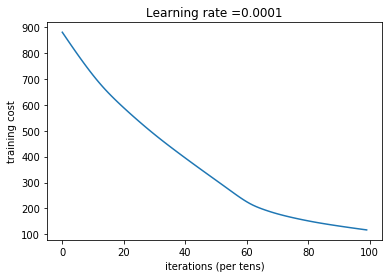

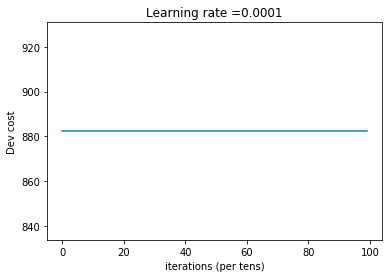

Parameters have been trained!
Training set accuracy: 0.08558294
Dev set accuracy: 0.07962529


In [24]:
parameters = model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test)